In [ ]:
import numpy as np
import keras
from keras import layers     #######
import re
import string
from bs4 import BeautifulSoup
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from keras.datasets import imdb
from keras.utils import to_categorical, pad_sequences, text_dataset_from_directory
# from keras.layers import SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer


import matplotlib.pyplot as plt

2024-08-13 17:12:47.523924: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 17:12:47.524049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 17:12:47.646959: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## **1. Load and Arrange Dataset**

### 1.1. Load Dataset

In [ ]:
max_features = 20000  # Only consider the top 20k words
maxlen = 800  # Only consider the first 800 words of each movie review

In [ ]:
# Load vectorized dataset
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(
    num_words=max_features,
    skip_top=30,
    max_len = maxlen
    seed = 113
    )
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

# Use pad_sequence to standardize sequence length:
# this will truncate sequences longer than 800 words and zero-pad sequences shorter than 800 words.
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
25000 Training sequences
25000 Validation sequences


In [ ]:
x_train.shape

(25000, 800)

In [ ]:
x_train[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
y_train[:5]

array([1, 0, 0, 1, 0])

### 1.2. Clean Texts

In [ ]:
# Clean text data
def clean_text(text):
    '''
    This function removes html tags,
    punctuation, digits and lowercase
    text
    '''
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Lowercase the text
    text = text.lower()
    return text

**Так як ми завантажили підготовлений векторизований датасет (представлення токенів у числах), щоби почистити текст ми маємо декодувати його у текстову репрезентацію**

In [ ]:
# Function to decode and clean reviews
word_index = imdb.get_word_index()

def decode_review(encoded_review):
    '''
    The function decodes data into text representation
    and clean the text
    '''
    reverse_word_index = {v: k for k, v in word_index.items()}
    decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in encoded_review])
    return clean_text(decoded_review)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Decode reviews from digital representation to text and clean texts
x_train = [decode_review(review) for review in tqdm(x_train, desc="Processing training data")]
x_val = [decode_review(review) for review in tqdm(x_val, desc="Processing val data")]

Processing val data: 100%|██████████| 25000/25000 [05:36<00:00, 74.32it/s]


### 1.3. Tokenize the Text

In [ ]:
# Tokenize the text
tokenizer = Tokenizer(
    num_words=max_features,
    # Clean the text off symbols additionally in any case
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)

tokenizer.fit_on_texts(x_train)

In [ ]:
x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)

In [ ]:
# Pad sequences to ensure uniform input size
x_train = pad_sequences(x_train, maxlen=maxlen)
x_val = pad_sequences(x_val, maxlen=maxlen)

In [ ]:
x_train[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

## **2. Build the Model**

In [ ]:
# Input for variable-length sequences of integers
inputs = keras.Input(shape=(None,), dtype="int32")

# Embed each integer in a 128-dimensional vector
x = layers.Embedding(max_features, 128)(inputs)

# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)   # 64
x = layers.Bidirectional(layers.LSTM(32))(x)                          # 32

# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_7 (Embedding)         │ (None, None, 128)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, None, 128)      │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,700,097 (10.30 MB)

 Trainable params: 2,700,097 (10.30 MB)

 Non-trainable params: 0 (0.00 B)

## **3. Train the model**

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val), verbose=2)

Epoch 1/10
196/196 - 38s - 192ms/step - accuracy: 0.8018 - loss: 0.4325 - val_accuracy: 0.8677 - val_loss: 0.3212
Epoch 2/10
196/196 - 34s - 172ms/step - accuracy: 0.9202 - loss: 0.2151 - val_accuracy: 0.8730 - val_loss: 0.3356
Epoch 3/10
196/196 - 41s - 210ms/step - accuracy: 0.9620 - loss: 0.1172 - val_accuracy: 0.8614 - val_loss: 0.3968
Epoch 4/10
196/196 - 41s - 208ms/step - accuracy: 0.9738 - loss: 0.0842 - val_accuracy: 0.8553 - val_loss: 0.4272
Epoch 5/10
196/196 - 33s - 171ms/step - accuracy: 0.9822 - loss: 0.0605 - val_accuracy: 0.8520 - val_loss: 0.5525
Epoch 6/10
196/196 - 34s - 172ms/step - accuracy: 0.9890 - loss: 0.0421 - val_accuracy: 0.8522 - val_loss: 0.5534
Epoch 7/10
196/196 - 34s - 171ms/step - accuracy: 0.9899 - loss: 0.0369 - val_accuracy: 0.8438 - val_loss: 0.6158
Epoch 8/10
196/196 - 33s - 171ms/step - accuracy: 0.9893 - loss: 0.0385 - val_accuracy: 0.8504 - val_loss: 0.5942
Epoch 9/10
196/196 - 33s - 171ms/step - accuracy: 0.9926 - loss: 0.0275 - val_accuracy: 

## **4. Evaluate the trained model**

Test loss: 0.690174400806427
Test accuracy: 0.8422799706459045


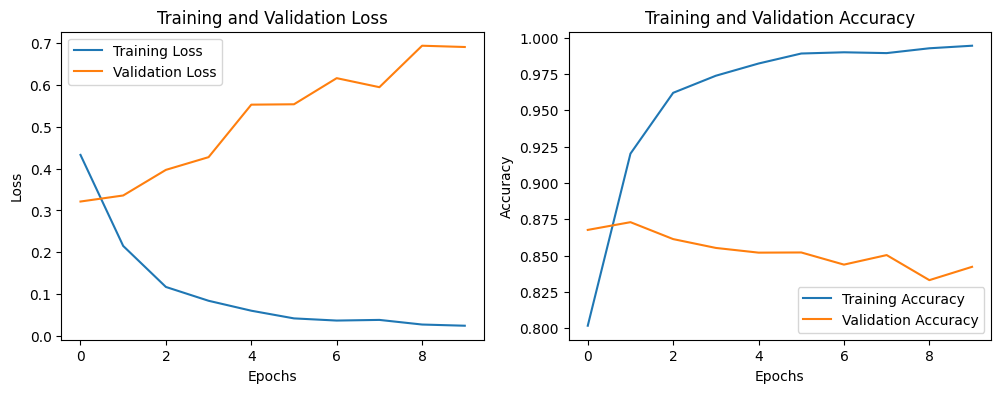

In [ ]:
# Evaluate the model
score = model.evaluate(x_val, y_val, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Plot the train and val loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the train and val accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**Судячі з метрик знятих в процесі тренування, модель оверфітиться вже на другій епосі і далі втрачає якість, якщо дивитися на валідаційних даних.**